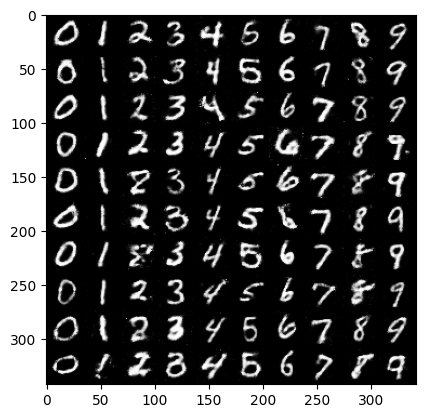

[Epoch 50/200] [Batch 301/938] [D loss: 0.173281] [G loss: 0.393500]
[Epoch 50/200] [Batch 302/938] [D loss: 0.150399] [G loss: 0.648910]
[Epoch 50/200] [Batch 303/938] [D loss: 0.166161] [G loss: 0.387724]
[Epoch 50/200] [Batch 304/938] [D loss: 0.141610] [G loss: 0.588353]
[Epoch 50/200] [Batch 305/938] [D loss: 0.196748] [G loss: 0.704740]
[Epoch 50/200] [Batch 306/938] [D loss: 0.220066] [G loss: 0.210870]
[Epoch 50/200] [Batch 307/938] [D loss: 0.153231] [G loss: 0.387767]
[Epoch 50/200] [Batch 308/938] [D loss: 0.279615] [G loss: 1.011422]
[Epoch 50/200] [Batch 309/938] [D loss: 0.291241] [G loss: 0.108202]
[Epoch 50/200] [Batch 310/938] [D loss: 0.277054] [G loss: 0.115944]
[Epoch 50/200] [Batch 311/938] [D loss: 0.224811] [G loss: 0.181216]
[Epoch 50/200] [Batch 312/938] [D loss: 0.172178] [G loss: 0.376170]
[Epoch 50/200] [Batch 313/938] [D loss: 0.174694] [G loss: 0.606869]
[Epoch 50/200] [Batch 314/938] [D loss: 0.190552] [G loss: 0.515635]
[Epoch 50/200] [Batch 315/938] [D 

KeyboardInterrupt: 

In [4]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs("images", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--n_classes", type=int, default=10, help="number of classes for dataset")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=100, help="interval between image sampling")
opt = parser.parse_args([])
print(opt)

img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(opt.n_classes, opt.n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim + opt.n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(opt.n_classes, opt.n_classes)

        self.model = nn.Sequential(
            nn.Linear(opt.n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity


# Loss functions
adversarial_loss = torch.nn.MSELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
from IPython.display import clear_output

def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, opt.latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)
    path='images/{0:}.png'.format(batches_done)
    img=plt.imread(path)
    plt.imshow(img)
    plt.show()
    
# ----------
#  Training
# ----------

for epoch in range(opt.n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, opt.n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            clear_output()
            sample_image(n_row=10, batches_done=batches_done)


In [1]:
import torch
from torch import nn
import numpy as np
from torchvision import datasets,transforms
import torchvision
import matplotlib.pyplot as plt
import cv2
from IPython.display import clear_output
cv2.setNumThreads(0)

cv2.ocl.setUseOpenCL(False)

In [46]:
#image_size=(64,64)

nc=1
class Generator(nn.Module):
    def __init__(self,z_dim,n_class):
        super().__init__()
        """
        input_shape (z_dim+n_class,1,1)
        out_shape(nc,128,128)
        """
        self.label_emb=nn.Embedding(n_class,n_class)
        def block(c_in,c_out,scale_rate,activation):
            net=[]
            net.append(nn.Upsample(scale_factor=scale_rate))
            net.append(nn.Conv2d(c_in,c_out,kernel_size=5,stride=1,padding=2))
            if activation=='R':
                net.append(nn.BatchNorm2d(c_out))
                net.append(nn.LeakyReLU(0.2))
            else:
                net.append(nn.Tanh())
            return nn.Sequential(*net)
        self.net=[]
        c_in_list=[z_dim+n_class,128,32,16,8]
        c_out_list=[128,32,16,8,nc]
        scale_rate_list=[4,2,2,2,2]
        activation_list=['R','R','R','R','T']
        
        for c_in,c_out,scale_rate,activation in zip(c_in_list,c_out_list,scale_rate_list,activation_list):
            self.net.append(block(c_in,c_out,scale_rate,activation))
        self.generator=nn.Sequential(*self.net)
        
    def forward(self,x,label):
        label_emb=self.label_emb(label).unsqueeze(1)
        x=x.unsqueeze(1).unsqueeze(1)
        #print(x)
        #x=self.generator(x)
        input_x=torch.cat([x,label_emb],dim=-1)
        #print(x.shape)
        #print(label_emb.shape)
        #print(input_x.shape)
        return self.generator(input_x.transpose(1,-1))
g=Generator(100,10)
labels=torch.ones((32,1)).type(torch.LongTensor)
z=torch.FloatTensor(np.random.normal(0, 1, (32,100)))
g(z,labels).shape

        

torch.Size([32, 1, 64, 64])

In [47]:
img_shape=(1,64,64)
class Reshape(nn.Module):
    def __init__(self,new_shape):
        super().__init__()
        self.new_shape=new_shape
    def forward(self,x):
        return x.view(self.new_shape)
        
class Discriminator(nn.Module):
    def __init__(self,n_class):
        super().__init__()
        self.label_embedding = nn.Embedding(n_class,n_class)
        def block(c_in,c_out,activation):
            net=[]
            net.append(nn.Conv2d(c_in,c_out,kernel_size=5,stride=2,padding=2))
            if activation=='R':
                #net.append(nn.BatchNorm2d(c_out))
                net.append(nn.LeakyReLU(0.2))
                net.append(nn.Dropout(0.4))
            else:
                net.append(nn.Sigmoid())
            return nn.Sequential(*net)
        
        self.model = nn.Sequential(
            #nn.Linear(n_class + int(np.prod(img_shape)), 1024),
            #nn.LeakyReLU(0.2, inplace=True),
            #Reshape((-1,1,32,32)),
            *block(n_class+1,16,'R'),
            *block(16,32,'R'),
            *block(32,128,'R'),
            *block(128,8,'R'),
            nn.Flatten(),
            nn.Linear(128,1),
            #nn.Sigmoid()
        )
        #self.fc=nn.Linear(32+n_class,1)
    def forward(self,x,label):
        label_emb=self.label_embedding(label).reshape(x.shape[0],-1,1,1)
        #print(label_emb.shape)
        label_emb = label_emb.repeat(1, 1, 64, 64)
        #x=x.reshape(x.shape[0],-1)
        #print(label_emb.shape)
        #print(x.shape)
        input_x=torch.cat([x,label_emb],dim=1)
        #print(input_x.shape)
        return self.model(input_x)
    
labels=torch.ones((32,1)).type(torch.LongTensor)
z=torch.FloatTensor(np.random.normal(0, 1, (32,1,64,64)))
D=Discriminator(10)
D(z,labels).shape

torch.Size([32, 1])

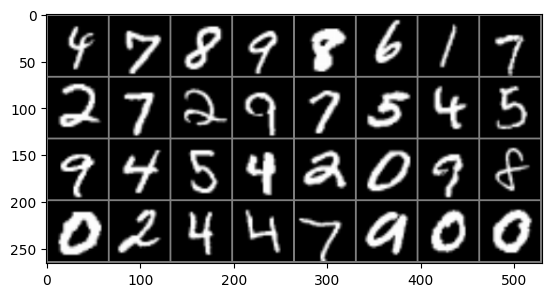

In [41]:

transform=transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

train_dataset=datasets.MNIST(root='./data',train=True,transform=transform,download=True)
test_dataset=datasets.MNIST(root='./data',train=False,transform=transform,download=True)

batch_size=32
train_dataloader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_dataloader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)

images,labels=next(iter(train_dataloader))

#拼接多张图片
img=torchvision.utils.make_grid(images,nrow=8,padding=2)
img=img.numpy().transpose(1, 2, 0)
#(h,w,c)变(c,h,w)

img=img*0.5+0.5

plt.imshow(img)
plt.show()

img =img.transpose((2,0,1))
torchvision.utils.save_image(torch.from_numpy(img).unsqueeze(0),'./data/1.png')

In [50]:
MSE = torch.nn.MSELoss()
z_dim=100
n_class=10
G = Generator(z_dim,n_class)
D= Discriminator(n_class)
lr=0.0002
optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))
#scheduler_D = torch.optim.lr_scheduler.ExponentialLR(optimizer_D, 0.5, -1)

device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
epochs=50

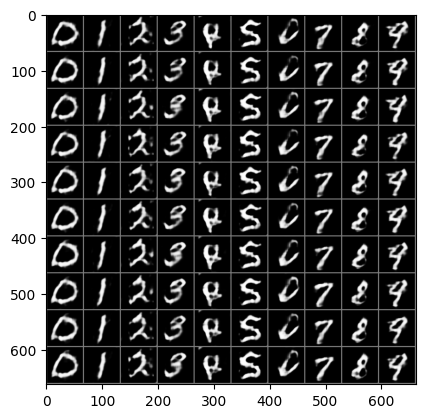

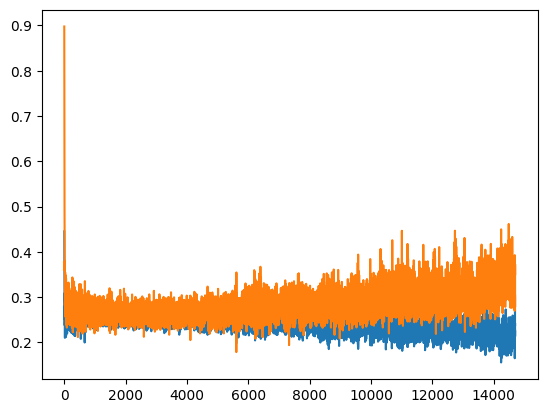

[Epoch 7/50] [Batch 1576/1875] [D loss: 0.239836] [G loss: 0.285237]
[Epoch 7/50] [Batch 1577/1875] [D loss: 0.244079] [G loss: 0.332565]
[Epoch 7/50] [Batch 1578/1875] [D loss: 0.222673] [G loss: 0.318415]
[Epoch 7/50] [Batch 1579/1875] [D loss: 0.258323] [G loss: 0.267531]
[Epoch 7/50] [Batch 1580/1875] [D loss: 0.229720] [G loss: 0.306482]
[Epoch 7/50] [Batch 1581/1875] [D loss: 0.204064] [G loss: 0.299285]
[Epoch 7/50] [Batch 1582/1875] [D loss: 0.253355] [G loss: 0.303387]
[Epoch 7/50] [Batch 1583/1875] [D loss: 0.237320] [G loss: 0.287426]
[Epoch 7/50] [Batch 1584/1875] [D loss: 0.209376] [G loss: 0.368158]
[Epoch 7/50] [Batch 1585/1875] [D loss: 0.264950] [G loss: 0.303994]


KeyboardInterrupt: 

In [51]:
G.to(device)
D.to(device)
D_total_loss=[]
G_total_loss=[]
for i in range(epochs):
    for batch,(x,label) in enumerate(train_dataloader):
        labels=torch.Tensor(label).type(torch.LongTensor).to(device)
        real_img=x.to(device)
        #print(real_img.shape)
        vaild=torch.ones((batch_size,1)).to(device)
        fake=torch.zeros((batch_size,1)).to(device)
        
        #训练生成器
        #for k in range(3):
        optimizer_G.zero_grad()

        noise=torch.FloatTensor(np.random.normal(0,1,(batch_size,z_dim))).to(device)
        gen_labels=torch.LongTensor(np.random.randint(0,n_class,(batch_size,1))).to(device)

        fake_img=G(noise,gen_labels)
        #print(fake_img.shape)
        D_fake=D(fake_img,gen_labels)
        #print(D_fake.shape,vaild.shape)
        g_loss=MSE(D_fake,vaild)
        g_loss.backward()
        optimizer_G.step()
        
        #训练判别器
        
        optimizer_D.zero_grad()
        
        D_real=D(real_img,labels)
        D_fake=D(fake_img.detach(),gen_labels)
        
        D_real_loss=MSE(D_real,vaild)
        D_fake_loss=MSE(D_fake,fake)
        #print(D_real_loss,D_fake_loss)
        d_loss=(D_real_loss+D_fake_loss)/2
        d_loss.backward()
        optimizer_D.step()
        
        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (i, epochs, batch, len(train_dataloader), d_loss.item(), g_loss.item())
        )
        D_total_loss.append(d_loss.item())
        G_total_loss.append(g_loss.item())
        batches_done = i * len(train_dataloader) + batch
        if batches_done%100==0:
            clear_output()
            n_row=10
            with torch.no_grad():
                labels = np.array([num for _ in range(n_row) for num in range(n_row)]).reshape((n_row*n_row,1))
                labels=torch.LongTensor(labels).to(device)
                z = torch.FloatTensor(np.random.normal(0, 1, (n_row ** 2, z_dim))).to(device)
                #print(z.shape,labels.shape)
                fake_img=G(z,labels)
                img=torchvision.utils.make_grid(fake_img,nrow=10,padding=2)
                img=img.detach().cpu().numpy().transpose(1, 2, 0)
                img=img*0.5+0.5
                plt.savefig('{}.png'.format(batches_done))
                plt.imshow(img)
                plt.show()
                plt.figure()
                plt.plot(range(batches_done+1),D_total_loss)
                plt.plot(range(batches_done+1),G_total_loss)
                plt.show()
                
    #scheduler_D.step()
    
        #break

In [28]:
print(optimizer_D.lr)

AttributeError: 'Adam' object has no attribute 'lr'

In [5]:
pip install torchsummary

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from torchsummary import summary
summart()